In [56]:
import requests
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import csv
import json
import pickle

In [57]:
companyCode = "GP"
months = 24 
analyze_size = 45
epochs = 4

stock_model = {
    'code' : companyCode,
    'month' : months,
    'size' : analyze_size,
    'epoch' : epochs,
    'algo' : 'LSTM'
}
with open('./json/' + companyCode + '.json', 'w') as f:  # writing JSON object
    json.dump(stock_model, f)

In [58]:
def fetchStockData( code, n ):
    url = 'https://www.dsebd.org/php_graph/monthly_graph.php?inst=' + code + '&duration=' + str(n) + '&type=price'
    r = requests.get(url)
    r.text
    data = r.text
    companyCode = data.split("Closing Price Graph of ",1)[1].split('\'')[0]
    d = data.split('\\n')
    del d[0]
    del d[-1]
    for i in range(0, len(d)):
        if(i == 0):
            d[i] = d[i].split('" +\r\n    "')[1]
        else:
            d[i] = d[i].split('"+"')[1]

    stock2dList = []
    for i in range(len(d)):
        arr = d[i].split(",")
        arr[1] = float(arr[1])
        stock2dList.append(arr)

    df = pd.DataFrame(stock2dList)
    df.columns =['Date','Price']

    print("---------------------------------")
    print("Trading Code: " + code)
    print("---------------------------------")
    print("Days: " + str(df.shape[0]))
    print("---------------------------------")
    df = df.set_index(pd.to_datetime(df['Date']))
    del df['Date']
    return df

---------------------------------
Trading Code: GP
---------------------------------
Days: 479
---------------------------------
Epoch 1/4
338/338 [==============================] - 9s 27ms/step - loss: 0.0062
Epoch 2/4
338/338 [==============================] - 8s 24ms/step - loss: 0.0032:
Epoch 3/4
338/338 [==============================] - 9s 25ms/step - loss: 0.0027
Epoch 4/4
338/338 [==============================] - 10s 30ms/step - loss: 0.0022
RMSE: 9.369821391858554


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


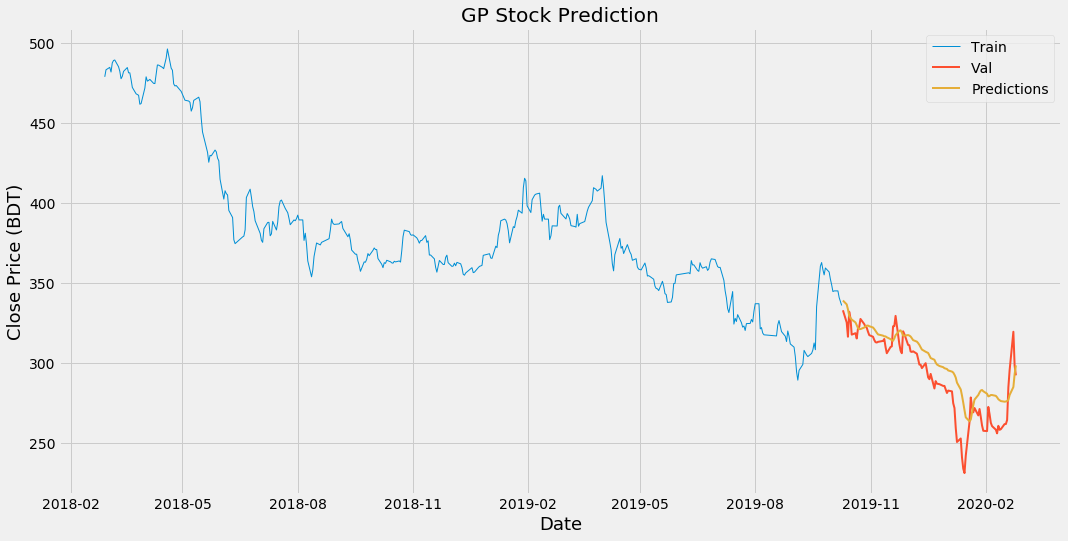

In [59]:
df = fetchStockData( companyCode, months )

# create dataframe only with close column
data = df.filter(['Price'])[:-1]
# dataframe to numpy array
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

pickle.dump(scaler, open('./pickles/' + companyCode + '_scaler.pkl', 'wb'))

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(analyze_size, len(train_data)):
    x_train.append(train_data[i-analyze_size:i, 0])
    y_train.append(train_data[i, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=epochs)

#create a new array containing scaled values
test_data = scaled_data[training_data_len-analyze_size: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(analyze_size, len(test_data)):
    x_test.append(test_data[i-analyze_size:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print("RMSE: " + str(rmse))

# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,8))
plt.title(companyCode + ' Stock Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (BDT)', fontsize=18)
plt.plot(train['Price'], linewidth = 1)
plt.plot(valid, linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()

In [60]:
predDf = df.filter(['Price'])
last_60_days = predDf[-(analyze_size+1):-1]
last_60_days_scaled = scaler.transform(last_60_days)
pred_test = []
pred_test.append(last_60_days_scaled)
pred_test = np.array(pred_test)
pred_test = np.reshape(pred_test, (pred_test.shape[0], pred_test.shape[1], 1))
pred_price = model.predict(pred_test)
pred_price = scaler.inverse_transform(pred_price)
print(df.tail(1))
print(predDf.tail(1))
print(pred_price[0])

            Price
Date             
2020-02-26  288.1
            Price
Date             
2020-02-26  288.1
[301.3707]


In [61]:
df

,Price
Date,
2018-02-28,478.7
2018-03-01,483.1
2018-03-04,484.6
2018-03-05,481.7
2018-03-06,487.4
...,...
2020-02-20,295.6
2020-02-23,319.6
2020-02-24,298.4


In [62]:
pd.to_pickle(model, './pickles/' + companyCode + '.pkl')

In [63]:
m = pickle.load(open('./pickles/' + companyCode + '.pkl', 'rb'))

In [64]:
s = m.predict(pred_test)
scaler.inverse_transform(s)

array([[301.3707]], dtype=float32)

In [65]:
last_60_days

,Price
Date,
2019-12-23,288.8
2019-12-24,287.2
2019-12-26,286.9
2019-12-29,285.8
2019-12-30,285.8
2020-01-01,281.4
2020-01-02,282.9
2020-01-05,282.4
2020-01-06,275.0


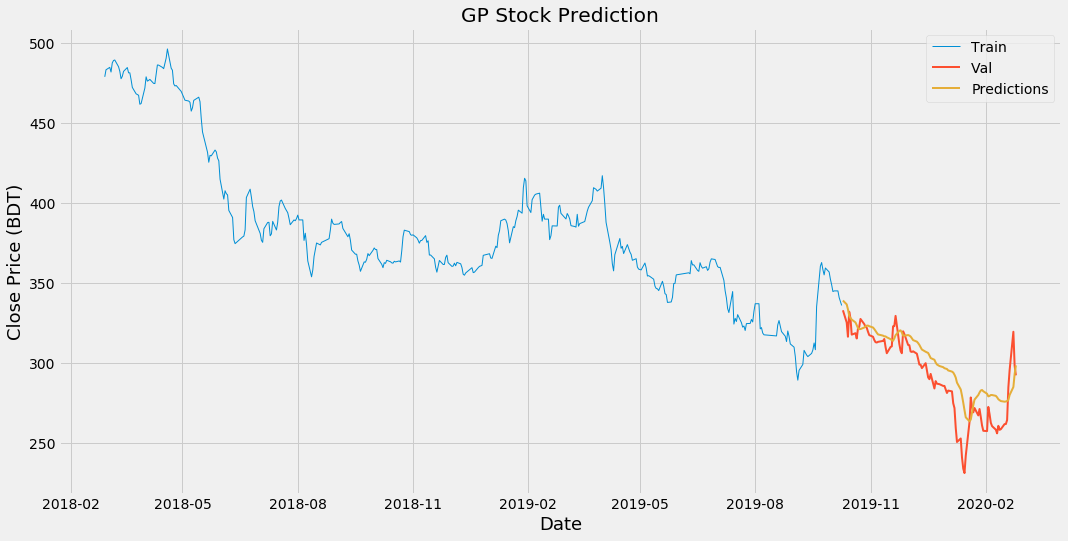

In [66]:

# visualize the data
plt.figure(figsize=(16,8))
plt.title(companyCode + ' Stock Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (BDT)', fontsize=18)
plt.plot(train['Price'], linewidth = 1)
plt.plot(valid, linewidth=2)
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()